# 載入資料

In [1]:
import pandas as pd

data_path = "./gnn_data/soc-sign-epinions/soc-sign-epinions.txt"

with open(data_path, "r") as f:
    all_txt_str = f.read().split("\n")
    txt_list = [txt_str.split("\t") for txt_str in all_txt_str[4:]]
    edge_df = pd.DataFrame(txt_list, columns=["FromNodeId","ToNodeId","Sign"])

In [2]:
edge_df = edge_df.dropna()
edge_df

,FromNodeId,ToNodeId,Sign
0,0,1,-1
1,1,128552,-1
2,2,3,1
3,4,5,-1
4,4,155,-1
...,...,...,...
841367,131821,366,1
841368,131822,112101,1
841369,131823,131824,1
841370,131825,131826,1


## 前處理+選出資料

In [3]:
edge_df["FromNodeId"] = edge_df["FromNodeId"].apply(int)
edge_df["ToNodeId"] = edge_df["ToNodeId"].apply(int)
edge_df["Sign"] = edge_df["Sign"].map({"1":1, "-1":0})

In [4]:
edge_df["Sign"].mean()

0.8529722881198804

In [5]:
Sign0_df = edge_df[edge_df["Sign"]==0]
node_set = set(Sign0_df["ToNodeId"])|set(Sign0_df["FromNodeId"])
choose_df = edge_df[
    edge_df["FromNodeId"].isin(node_set)&edge_df["ToNodeId"].isin(node_set)
]

In [6]:
choose_df["Sign"].mean()

0.781427185683971

In [7]:
ChooseSign0_df = choose_df[choose_df["Sign"]==0]
ChooseSign1_df = choose_df[choose_df["Sign"]==1]

In [9]:
ChooseSign1_df = ChooseSign1_df.sample(int(len(ChooseSign0_df)*1.5))
choose_df = pd.concat([ChooseSign0_df, ChooseSign1_df]).sample(frac=1)

In [10]:
choose_df["Sign"].mean()

0.5999993532991444

# 轉成tensor

In [11]:
import torch as th

class IdEncoder:
    def __init__(self, NodeName_set):
        self.NodeId_dict = {
            NodeName: idx for idx, NodeName in enumerate(sorted(NodeName_set))
        }

    def __len__(self):
        return len(self.NodeId_dict)

    @property
    def NodeName_set(self):
        return set(self.NodeId_dict.keys())

    @property
    def max_id(self):
        return max(self.NodeId_dict.values())

    @property
    def IdNode_dict(self):
        return {idx:NodeName for NodeName, idx in self.NodeId_dict.items()}

    def node_to_id(self, node):
        return self.NodeId_dict.get(node)

    def id_to_node(self, id):
        for NodeName, idx in self.NodeId_dict.items():
            if idx==id: return NodeName
        return None

    def update(self, NodeName_set):
        NewNodeName_set = NodeName_set - self.NodeName_set
        self.NodeId_dict.update({
            NodeName: idx+self.max_id
            for idx, NodeName in enumerate(sorted(NewNodeName_set))
        })


/home/zhu4/anaconda3/envs/pyg/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
encode = IdEncoder(node_set)

In [13]:
from_list = choose_df["FromNodeId"].map(encode.NodeId_dict).tolist()
to_list = choose_df["ToNodeId"].map(encode.NodeId_dict).tolist()
sign_list = choose_df["Sign"].tolist()

In [14]:
node_attr_ts = th.ones(len(encode)).float().reshape(-1, 1)
edge_index_ts = th.tensor([from_list, to_list]).long()
edge_label_ts = th.tensor(sign_list).float().reshape(-1, 1)

# 製作graph

In [16]:
from torch_geometric.data import Data

data = Data(x=node_attr_ts, edge_index=edge_index_ts, edge_attr=edge_label_ts, edge_label=edge_label_ts)

/home/zhu4/anaconda3/envs/pyg/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [19]:
data

Data(x=[43347, 1], edge_index=[2, 309262], edge_attr=[309262, 1], edge_label=[309262, 1])

In [28]:
from torch_geometric.transforms import RandomLinkSplit

train_data, val_data, test_data = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=False,
    neg_sampling_ratio=0.0,
    disjoint_train_ratio=0.2,
)(data)

In [23]:
data

Data(x=[43347, 1], edge_index=[2, 309262], edge_attr=[309262, 1], edge_label=[309262, 1])

# 建立模型

In [317]:
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn.dense import Linear

class GATEncoder(th.nn.Module):
    def __init__(self, encoder_size):
        super().__init__()

        hidden_channels, out_channels = encoder_size
        self.conv1 = GATv2Conv(
            (-1, -1), hidden_channels, edge_dim=1, add_self_loops=False
        )
        self.lin1 = Linear(-1, hidden_channels)
        self.conv2 = GATv2Conv(
            (-1, -1), out_channels, edge_dim=1, add_self_loops=False
        )
        self.lin2 = Linear(-1, out_channels)
        self.conv3 = GATv2Conv(
            (-1, -1), out_channels, edge_dim=1, add_self_loops=False
        )
        self.lin3 = Linear(-1, out_channels)
        self.conv4 = GATv2Conv(
            (-1, -1), out_channels, edge_dim=1, add_self_loops=False
        )
        self.lin4 = Linear(-1, out_channels)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr) + self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr) + self.lin2(x)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_attr) + self.lin3(x)
        x = x.relu()
        x = self.conv4(x, edge_index, edge_attr) + self.lin4(x)
        x = x.relu()
        return x

class EdgeDecoder(th.nn.Module):

    def __init__(self, decoder_size):
        super().__init__()
        hidden_channels = decoder_size
        self.lin1 = Linear(-1, hidden_channels)
        self.lin2 = Linear(-1, 1)

    def forward(self, NodeConvH_ts, edge_label_index):
        from_ts, to_ts = edge_label_index
        NodeH_ts = th.cat([NodeConvH_ts[from_ts], NodeConvH_ts[to_ts]], dim=-1)
        x = self.lin1(NodeH_ts).relu()
        x = self.lin2(x).sigmoid()
        return x

class GNN(th.nn.Module):
    def __init__(self, encoder_size, decoder_size):
        super().__init__()
        self.encoder = GATEncoder(encoder_size)
        self.decoder = EdgeDecoder(decoder_size)

    def forward(self, x, edge_index, edge_attr, edge_label_index):
        NodeConvH_ts = self.encoder(x, edge_index, edge_attr)
        return self.decoder(NodeConvH_ts, edge_label_index)


## 試跑一下

In [288]:
model = GNN((4, 12), 12)
edge_pred = model(
    x=train_data.x,
    edge_index=train_data.edge_index,
    edge_attr=train_data.edge_attr,
    edge_label_index=train_data.edge_label_index
)

edge_pred

tensor([[0.4603],
        [0.4549],
        [0.4550],
        ...,
        [0.4603],
        [0.4557],
        [0.4566]], grad_fn=<SigmoidBackward0>)

In [289]:
edge_label = train_data.edge_label.reshape(-1, 1)
edge_label

tensor([[1.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]])

In [290]:
import torch.nn.functional as F

F.binary_cross_entropy(edge_pred, edge_label)

tensor(0.7168, grad_fn=<BinaryCrossEntropyBackward0>)

# 訓練

In [318]:

def get_pred(data, model):
    return model(
        x=data.x,
        edge_index=data.edge_index,
        edge_attr=data.edge_attr,
        edge_label_index=data.edge_label_index
    )

@th.no_grad()
def get_pred_no_grad(data, model):
    return model(
        x=data.x,
        edge_index=data.edge_index,
        edge_attr=data.edge_attr,
        edge_label_index=data.edge_label_index
    )

@th.no_grad()
def get_loss_in_eval(data, model):
    model.eval()
    pred = get_pred_no_grad(data, model)
    target = data.edge_label.reshape(-1, 1)
    loss = F.binary_cross_entropy(pred, target)
    return loss

def get_loss(data, model):
    pred = get_pred(data, model)
    target = data.edge_label.reshape(-1, 1)
    loss = F.binary_cross_entropy(pred, target)
    return loss

In [321]:
from pytorchtools import EarlyStopping

model = GNN((4, 6), 12)
# model = th.load("checkpoint.pt")
optimizer = th.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
early_stopping = EarlyStopping(patience=30, verbose=False)

In [322]:

trainLoss_list = []
valLoss_list = []

for epoch in range(0, 2000):
    model.train()
    optimizer.zero_grad()

    train_loss = get_loss(train_data, model)
    train_loss.backward()

    optimizer.step()
    scheduler.step(train_loss)

    val_loss = get_loss_in_eval(val_data, model)

    trainLoss_list.append(train_loss.detach().numpy())
    valLoss_list.append(val_loss.detach().numpy())

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, val_Loss: {val_loss:.4f}')

Epoch: 000, Loss: 0.7305, val_Loss: 0.7255
Epoch: 001, Loss: 0.7250, val_Loss: 0.7041
Epoch: 002, Loss: 0.7036, val_Loss: 0.6820
Epoch: 003, Loss: 0.6814, val_Loss: 0.6657
Epoch: 004, Loss: 0.6649, val_Loss: 0.6576
Epoch: 005, Loss: 0.6564, val_Loss: 0.6557
EarlyStopping counter: 1 out of 30
Epoch: 006, Loss: 0.6538, val_Loss: 0.6604
EarlyStopping counter: 2 out of 30
Epoch: 007, Loss: 0.6579, val_Loss: 0.6646
EarlyStopping counter: 3 out of 30
Epoch: 008, Loss: 0.6618, val_Loss: 0.6632
EarlyStopping counter: 4 out of 30
Epoch: 009, Loss: 0.6605, val_Loss: 0.6586
Epoch: 010, Loss: 0.6563, val_Loss: 0.6548
Epoch: 011, Loss: 0.6529, val_Loss: 0.6537
EarlyStopping counter: 1 out of 30
Epoch: 012, Loss: 0.6523, val_Loss: 0.6546
EarlyStopping counter: 2 out of 30
Epoch: 013, Loss: 0.6534, val_Loss: 0.6553
EarlyStopping counter: 3 out of 30
Epoch: 014, Loss: 0.6543, val_Loss: 0.6546
Epoch: 015, Loss: 0.6536, val_Loss: 0.6526
Epoch: 016, Loss: 0.6514, val_Loss: 0.6503
Epoch: 017, Loss: 0.6491

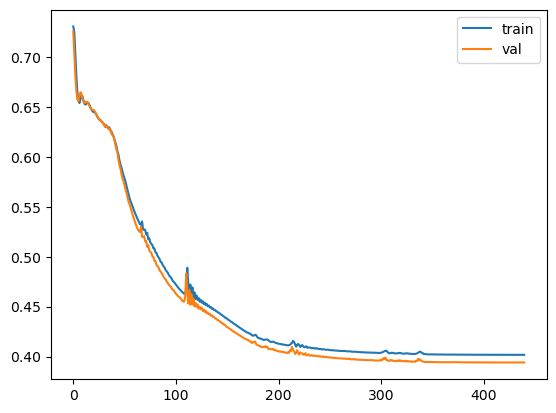

In [323]:
import matplotlib.pyplot as plt

plt.plot(trainLoss_list, label='train')
plt.plot(valLoss_list, label='val')
plt.legend()
plt.show()

# 測試

In [324]:
model = th.load("checkpoint.pt")

In [325]:
model.eval()
test_pred = get_pred_no_grad(test_data, model)
test_loss = get_loss_in_eval(test_data, model)
test_target = test_data.edge_label.reshape(-1, 1)
test_accuracy = th.mean(((test_pred>0.5)==test_target).float())

In [326]:
test_loss

tensor(0.3909)

In [328]:
test_accuracy

tensor(0.8344)

[[ 9115  3172]
 [ 1948 16691]]
Normalized confusion matrix


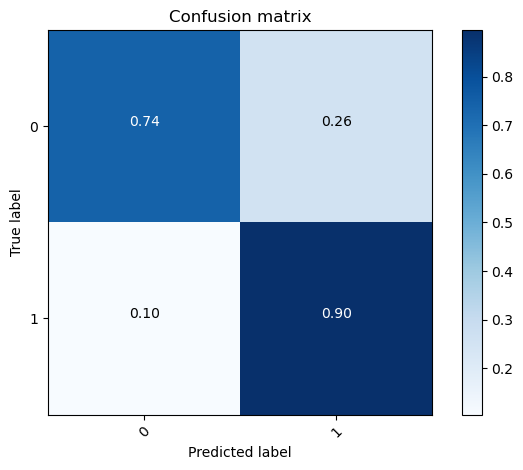

In [332]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(test_target, (test_pred>0.5))
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

In [333]:
from sklearn.metrics import classification_report

print(classification_report(test_target, (test_pred>0.5)))

              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78     12287
         1.0       0.84      0.90      0.87     18639

    accuracy                           0.83     30926
   macro avg       0.83      0.82      0.82     30926
weighted avg       0.83      0.83      0.83     30926

